In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
import bout.assembly as bt
import comparison.data_assembly as comp
import comparison.plot as complot
from core import SITE_NAMES

from cli import get_file_paths
import plot
import pipeline

In [4]:
def get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p):
    points_dc = pd.DataFrame(plt_dcmetr.values, columns=['values'], index=plt_dcmetr.index)
    points_c = pd.DataFrame(plt_cmetr.values, columns=['values'], index=plt_cmetr.index)
    total_num_points = points_dc.shape[0]

    within_bounds = ((points_dc.values<=points_c.values*(1+p))&(points_dc.values>=points_c.values*(1-p)))
    num_points_in_bounds = np.sum(within_bounds.astype(int), axis=0)
    percent_points_in_bounds = num_points_in_bounds / total_num_points
    all_points_bound = p[percent_points_in_bounds==1][0]

    test_true_100_at_factor(points_dc, points_c, all_points_bound)

    return percent_points_in_bounds

def test_true_100_at_factor(points_dc, points_c, p):
    test_dc = points_dc[points_dc!=0].dropna()
    test_c = points_c.loc[test_dc.index]
    filt_dc = (test_dc.values>test_c.values*(1+p))|(test_dc.values<test_c.values*(1-p))
    assert filt_dc.all()==False

def get_percent_points_in_bounds_linear(plt_dcmetr, plt_cmetr, p):
    points_dc = pd.DataFrame(plt_dcmetr.values, columns=['activity_inds'], index=plt_dcmetr.index)
    points_c = pd.DataFrame(plt_cmetr.values, columns=['activity_inds'], index=plt_cmetr.index)
    total_num_points = points_dc.shape[0]

    within_bounds = ((points_dc.values<=points_c.values+(100*p))&(points_dc.values>=points_c.values-(100*p)))
    num_points_in_bounds = np.sum(within_bounds.astype(int), axis=0)
    percent_points_in_bounds = num_points_in_bounds / total_num_points

    return percent_points_in_bounds

def plot_variance_of_points_linear(plt_dcmetr, plt_cmetr, data_params): 
    dc_tag_split = re.findall(r"\d+", plt_dcmetr.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    dctag1 = re.search(r"\d+of\d+", plt_dcmetr.columns[0])[0]

    step = 0.01
    p = np.arange(0, 1+step, step)
    percent_points_in_bounds = get_percent_points_in_bounds_linear(plt_dcmetr, plt_cmetr, p)
    points_on_line = percent_points_in_bounds[0]
    all_points_bound = p[percent_points_in_bounds==1.0][0]
    most_points_bound = p[percent_points_in_bounds>=0.95][0]

    plt.title(f'{data_params["metric_tag"]} ({dctag1}) and cont.')
    plt.plot(p, percent_points_in_bounds)
    plt.axhline(y=points_on_line, label=f'{round(100*points_on_line)}% of points on line',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=most_points_bound, label=f'>=95% at {round(100*most_points_bound)}% bounds',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=all_points_bound, label=f'100% at {round(100*all_points_bound)}% bounds',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.grid(which='both')
    plt.xlabel('% bounds')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.ylabel('% of scattered points within bounds')
    plt.legend(loc=4)

def plot_variance_of_points_log(plt_dcmetr, plt_cmetr, data_params): 
    dc_tag_split = re.findall(r"\d+", plt_dcmetr.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    dctag1 = re.search(r"\d+of\d+", plt_dcmetr.columns[0])[0]

    p = np.arange(0, 6+0.01, 0.01) + 1e-14
    percent_points_in_bounds = get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p)
    points_on_line = percent_points_in_bounds[0]
    upper_bound_points = (1/listening_ratio)-1
    zero_bound_points = 1.0

    plt.title(f'{data_params["metric_tag"]} ({dctag1}) and cont.')
    plt.plot(p, percent_points_in_bounds)
    plt.axhline(y=points_on_line, label=f'{round(100*points_on_line)}% of points on line',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=zero_bound_points, label=f'zeros captured at p={zero_bound_points}',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=upper_bound_points, label=f'upper-bound captured at p={upper_bound_points}',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.grid(which='both')
    plt.xlabel('% bounds')
    plt.xlim(-0.1, 6.1)
    plt.ylim(-0.1, 1.1)
    plt.ylabel('% of scattered points within bounds')
    plt.legend(loc=4)

def plot_all_dc_scheme_variance_of_points_linear(dc_activity_arr, c_activity_arr, data_params):
    plt.figure(figsize=(4.5*len(data_params['percent_ons']), 4.5*len(data_params['cycle_lengths'])))
    plt.rcParams.update({'font.size':12})
    for i, dc_col in enumerate(data_params["dc_tags"][1:]):
        plt.subplot(len(data_params['cycle_lengths']), len(data_params['percent_ons']), i+1)
        metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
        cycle_length = int(dc_col.split('of')[-1])
        cont_tag = f'{cycle_length}of{cycle_length}'
        cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
        metric_for_scheme = pd.DataFrame(dc_activity_arr.loc[:,metric_col_name].dropna())
        cont_column = pd.DataFrame(c_activity_arr.loc[:,cont_metric_col_name].dropna())
        metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
        plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
        plot_variance_of_points_linear(plt_dcmetr, plt_cmetr, data_params)

    plt.tight_layout()
    plt.show()

def plot_all_dc_scheme_variance_of_points_log(dc_activity_arr, c_activity_arr, data_params):
    plt.figure(figsize=(4.5*len(data_params['percent_ons']), 4.5*len(data_params['cycle_lengths'])))
    plt.rcParams.update({'font.size':12})
    for i, dc_col in enumerate(data_params["dc_tags"][1:]):
        plt.subplot(len(data_params['cycle_lengths']), len(data_params['percent_ons']), i+1)
        metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
        cycle_length = int(dc_col.split('of')[-1])
        cont_tag = f'{cycle_length}of{cycle_length}'
        cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
        metric_for_scheme = pd.DataFrame(dc_activity_arr.loc[:,metric_col_name].dropna())
        cont_column = pd.DataFrame(c_activity_arr.loc[:,cont_metric_col_name].dropna())
        metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
        plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
        plot_variance_of_points_log(plt_dcmetr, plt_cmetr, data_params)

    plt.tight_layout()
    plt.show()

In [5]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

cycle_lengths = [6, 18, 30, 60, 120, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
data_params['index_time_block_in_secs'] = '5'
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

site_keys = ['Carp', 'Telephone', 'Central', 'Foliage']
type_keys = ['LF', 'HF']
data_params["dc_tags"] = dc_tags
data_params['cur_dc_tag'] = '30of30'
data_params['metric_tag'] = 'bout_time_percentage'
data_params['index_time_block'] = 5
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
dt_starts = {'Carp':dt.datetime(2022, 8, 10, 0, 0, 0),
             'Telephone':dt.datetime(2022, 8, 19, 0, 0, 0)}
dt_ends = {'Carp':dt.datetime(2022, 9, 30, 16, 0, 0),
           'Telephone':dt.datetime(2022, 9, 30, 16, 0, 0)}

for site_key in site_keys:
    # site_key = site_keys[1]
    # data_params['start'] = dt_starts[site_key]
    # data_params['end'] = dt_ends[site_key]
    for type_key in type_keys:
        # type_key = type_keys[0]
        print(site_key, type_key)
        data_params["site_tag"] = site_key
        data_params["site_name"] = SITE_NAMES[site_key]
        data_params["type_tag"] = type_key
        file_paths = get_file_paths(data_params)

        activity_arr, btp_arr = comp.generate_activity_btp_for_dc_schemes_and_cont(data_params, file_paths, save=True)

Carp LF
Carp HF
Telephone LF
Telephone HF
Central LF
Central HF
Foliage LF
Foliage HF


In [139]:
activity_arr = pd.DataFrame()
location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)

dc_schemes = data_params['dc_tags'][1:]
cont_scheme = data_params['dc_tags'][0]
btp_arr = pd.DataFrame()
prev_cycle = 0
# for dc_tag in dc_schemes:
dc_tag = '20of120'
metric_col_name = f'{data_params["metric_tag"]} ({dc_tag})'
cycle_length = int(dc_tag.split('of')[1])
dc_tag_split = re.findall(r"\d+", metric_col_name)
cycle_length = int(dc_tag_split[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cycle_length_in_secs = 60*cycle_length
data_params['cur_dc_tag'] = cont_tag

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
bout_params = bt.get_bout_params_from_location(dc_applied_df, data_params)
bout_metrics_cont = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, bout_params)

bout_duration_cont = actvt.get_bout_duration_per_cycle(bout_metrics_cont, cycle_length)
bout_time_percentage_cont = actvt.get_btp_per_time_on(bout_duration_cont, cycle_length_in_secs)
bout_time_percentage_cont_column = actvt.filter_and_prepare_metric(bout_time_percentage_cont, data_params)
bout_time_percentage_cont_column = bout_time_percentage_cont_column.set_index("datetime_UTC")
ss.are_there_expected_number_of_cycles(location_df, bout_time_percentage_cont_column, cycle_length, data_params)
bout_time_percentage_cont_column

,bout_time_percentage (120of120)
datetime_UTC,
2022-07-23 04:00:00,0.005172
2022-07-23 06:00:00,0.016974
2022-07-23 08:00:00,0.000000
2022-07-23 10:00:00,0.050346
2022-07-23 12:00:00,0.000000
...,...
2022-10-17 04:00:00,0.028529
2022-10-17 06:00:00,0.610144
2022-10-17 08:00:00,0.000000


In [140]:
dc_applied_df.loc[(dc_applied_df['call_start_time']>=dt.datetime(2022,9,14,6,0,0))&(dc_applied_df['call_end_time']<=dt.datetime(2022,9,14,8,0,0))]

,start_time_wrt_ref,end_time_wrt_ref,index_in_file,peak_frequency,index_in_summary,input_file_dt,freq_group,ref_time,call_start_time,call_end_time,...,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration,cycle_ref_time
622241,125.3795,125.3893,0,29760.0,626142,2022-09-14 06:00:00,LF,2022-09-14 06:02:05.379500000,2022-09-14 06:02:05.379500000,2022-09-14 06:02:05.389300000,...,Nyctalus leisleri,0.269,0.508,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622242,125.6445,125.6542,1,29760.0,626143,2022-09-14 06:00:00,LF,2022-09-14 06:02:05.644500000,2022-09-14 06:02:05.644500000,2022-09-14 06:02:05.654200000,...,Nyctalus leisleri,0.305,0.572,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622243,125.7745,125.7855,2,29760.0,626144,2022-09-14 06:00:00,LF,2022-09-14 06:02:05.774500000,2022-09-14 06:02:05.774500000,2022-09-14 06:02:05.785500000,...,Nyctalus leisleri,0.248,0.526,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622244,126.0215,126.0309,3,29760.0,626145,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.021500000,2022-09-14 06:02:06.021500000,2022-09-14 06:02:06.030900000,...,Nyctalus leisleri,0.363,0.631,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622245,126.1505,126.1586,4,29760.0,626146,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.150500000,2022-09-14 06:02:06.150500000,2022-09-14 06:02:06.158600000,...,Eptesicus serotinus,0.310,0.613,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622246,126.3515,126.3615,5,28800.0,626147,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.351500000,2022-09-14 06:02:06.351500000,2022-09-14 06:02:06.361500000,...,Nyctalus leisleri,0.405,0.762,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622247,126.4875,126.4959,6,28800.0,626148,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.487500000,2022-09-14 06:02:06.487500000,2022-09-14 06:02:06.495900000,...,Eptesicus serotinus,0.280,0.563,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622248,126.6225,126.6307,7,28800.0,626149,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.622500000,2022-09-14 06:02:06.622500000,2022-09-14 06:02:06.630700000,...,Eptesicus serotinus,0.343,0.642,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622249,126.7505,126.7592,8,28800.0,626150,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.750500000,2022-09-14 06:02:06.750500000,2022-09-14 06:02:06.759200000,...,Nyctalus leisleri,0.448,0.651,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622250,126.8815,126.8898,9,29760.0,626151,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.881500000,2022-09-14 06:02:06.881500000,2022-09-14 06:02:06.889800000,...,Nyctalus leisleri,0.388,0.671,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00


In [141]:
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
bout_metrics_fixed = bt.construct_bout_metrics_for_freqgroups_with_cycle_interval(tagged_dets, data_params)

In [142]:
tagged_dets.loc[(tagged_dets['call_start_time']>=dt.datetime(2022,9,14,6,0,0))&(tagged_dets['call_end_time']<=dt.datetime(2022,9,14,8,0,0))]

,call_status,change_markers,bout_tag,duration_from_last_call_ms,start_time_wrt_ref,end_time_wrt_ref,index_in_file,peak_frequency,index_in_summary,input_file_dt,...,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration,cycle_ref_time
3942,bout start,1.0,0,5.443612e+06,125.3795,125.3893,0,29760.0,626142,2022-09-14 06:00:00,...,Nyctalus leisleri,0.269,0.508,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
3943,within bout,0.0,1,2.552000e+02,125.6445,125.6542,1,29760.0,626143,2022-09-14 06:00:00,...,Nyctalus leisleri,0.305,0.572,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
3944,within bout,0.0,1,1.203000e+02,125.7745,125.7855,2,29760.0,626144,2022-09-14 06:00:00,...,Nyctalus leisleri,0.248,0.526,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
3945,within bout,0.0,1,2.360000e+02,126.0215,126.0309,3,29760.0,626145,2022-09-14 06:00:00,...,Nyctalus leisleri,0.363,0.631,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
3946,within bout,0.0,1,1.196000e+02,126.1505,126.1586,4,29760.0,626146,2022-09-14 06:00:00,...,Eptesicus serotinus,0.310,0.613,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
3947,within bout,0.0,1,1.929000e+02,126.3515,126.3615,5,28800.0,626147,2022-09-14 06:00:00,...,Nyctalus leisleri,0.405,0.762,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
3948,within bout,0.0,1,1.260000e+02,126.4875,126.4959,6,28800.0,626148,2022-09-14 06:00:00,...,Eptesicus serotinus,0.280,0.563,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
3949,within bout,0.0,1,1.266000e+02,126.6225,126.6307,7,28800.0,626149,2022-09-14 06:00:00,...,Eptesicus serotinus,0.343,0.642,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
3950,within bout,0.0,1,1.198000e+02,126.7505,126.7592,8,28800.0,626150,2022-09-14 06:00:00,...,Nyctalus leisleri,0.448,0.651,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
3951,within bout,0.0,1,1.223000e+02,126.8815,126.8898,9,29760.0,626151,2022-09-14 06:00:00,...,Nyctalus leisleri,0.388,0.671,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00


In [129]:
data_params['cur_dc_tag'] = dc_tag
cycle_length_in_mins = int(data_params['cur_dc_tag'].split('of')[1])
time_on_in_mins = int(data_params['cur_dc_tag'].split('of')[0])
time_on_in_secs = (60*time_on_in_mins)

dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
comp.does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df)
bout_params = bt.get_bout_params_from_location(dc_applied_df, data_params)
bout_metrics_dc = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, bout_params)
bout_duration_dc = actvt.get_bout_duration_per_cycle(bout_metrics_dc, cycle_length_in_mins)
bout_time_percentage_dc = actvt.get_btp_per_time_on(bout_duration_dc, time_on_in_secs)
bout_time_percentage_dc_column = actvt.filter_and_prepare_metric(bout_time_percentage_dc, data_params)
bout_time_percentage_dc_column = bout_time_percentage_dc_column.set_index("datetime_UTC")
ss.are_there_expected_number_of_cycles(dc_applied_df, bout_time_percentage_dc_column, cycle_length_in_mins, data_params)

bout_time_percentage_dc_column

,bout_time_percentage (20of120)
datetime_UTC,
2022-07-23 10:00:00,0.016600
2022-07-23 12:00:00,0.000000
2022-07-23 14:00:00,0.000000
2022-07-24 00:00:00,0.000000
2022-07-24 02:00:00,0.000000
...,...
2022-10-16 10:00:00,0.000000
2022-10-16 12:00:00,0.000000
2022-10-16 14:00:00,0.000000


In [133]:
dc_applied_df.loc[(dc_applied_df['call_start_time']>=dt.datetime(2022,9,14,6,0,0))&(dc_applied_df['call_end_time']<=dt.datetime(2022,9,14,8,0,0))]

,start_time_wrt_ref,end_time_wrt_ref,index_in_file,peak_frequency,index_in_summary,input_file_dt,freq_group,ref_time,call_start_time,call_end_time,...,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration,cycle_ref_time
622241,125.3795,125.3893,0,29760.0,626142,2022-09-14 06:00:00,LF,2022-09-14 06:02:05.379500000,2022-09-14 06:02:05.379500000,2022-09-14 06:02:05.389300000,...,Nyctalus leisleri,0.269,0.508,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622242,125.6445,125.6542,1,29760.0,626143,2022-09-14 06:00:00,LF,2022-09-14 06:02:05.644500000,2022-09-14 06:02:05.644500000,2022-09-14 06:02:05.654200000,...,Nyctalus leisleri,0.305,0.572,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622243,125.7745,125.7855,2,29760.0,626144,2022-09-14 06:00:00,LF,2022-09-14 06:02:05.774500000,2022-09-14 06:02:05.774500000,2022-09-14 06:02:05.785500000,...,Nyctalus leisleri,0.248,0.526,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622244,126.0215,126.0309,3,29760.0,626145,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.021500000,2022-09-14 06:02:06.021500000,2022-09-14 06:02:06.030900000,...,Nyctalus leisleri,0.363,0.631,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622245,126.1505,126.1586,4,29760.0,626146,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.150500000,2022-09-14 06:02:06.150500000,2022-09-14 06:02:06.158600000,...,Eptesicus serotinus,0.310,0.613,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622246,126.3515,126.3615,5,28800.0,626147,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.351500000,2022-09-14 06:02:06.351500000,2022-09-14 06:02:06.361500000,...,Nyctalus leisleri,0.405,0.762,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622247,126.4875,126.4959,6,28800.0,626148,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.487500000,2022-09-14 06:02:06.487500000,2022-09-14 06:02:06.495900000,...,Eptesicus serotinus,0.280,0.563,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622248,126.6225,126.6307,7,28800.0,626149,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.622500000,2022-09-14 06:02:06.622500000,2022-09-14 06:02:06.630700000,...,Eptesicus serotinus,0.343,0.642,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622249,126.7505,126.7592,8,28800.0,626150,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.750500000,2022-09-14 06:02:06.750500000,2022-09-14 06:02:06.759200000,...,Nyctalus leisleri,0.448,0.651,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
622250,126.8815,126.8898,9,29760.0,626151,2022-09-14 06:00:00,LF,2022-09-14 06:02:06.881500000,2022-09-14 06:02:06.881500000,2022-09-14 06:02:06.889800000,...,Nyctalus leisleri,0.388,0.671,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00


In [134]:
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
bout_metrics_fixed = bt.construct_bout_metrics_for_freqgroups_with_cycle_interval(tagged_dets, data_params)

In [137]:
tagged_dets.loc[(tagged_dets['call_start_time']>=dt.datetime(2022,9,14,6,0,0))&(tagged_dets['call_end_time']<=dt.datetime(2022,9,14,8,0,0))]

,call_status,change_markers,bout_tag,duration_from_last_call_ms,start_time_wrt_ref,end_time_wrt_ref,index_in_file,peak_frequency,index_in_summary,input_file_dt,...,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration,cycle_ref_time
294,bout start,1.0,0,6.385971e+07,125.3795,125.3893,0,29760.0,626142,2022-09-14 06:00:00,...,Nyctalus leisleri,0.269,0.508,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
295,within bout,0.0,1,2.552000e+02,125.6445,125.6542,1,29760.0,626143,2022-09-14 06:00:00,...,Nyctalus leisleri,0.305,0.572,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
296,within bout,0.0,1,1.203000e+02,125.7745,125.7855,2,29760.0,626144,2022-09-14 06:00:00,...,Nyctalus leisleri,0.248,0.526,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
297,within bout,0.0,1,2.360000e+02,126.0215,126.0309,3,29760.0,626145,2022-09-14 06:00:00,...,Nyctalus leisleri,0.363,0.631,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
298,within bout,0.0,1,1.196000e+02,126.1505,126.1586,4,29760.0,626146,2022-09-14 06:00:00,...,Eptesicus serotinus,0.310,0.613,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
299,within bout,0.0,1,1.929000e+02,126.3515,126.3615,5,28800.0,626147,2022-09-14 06:00:00,...,Nyctalus leisleri,0.405,0.762,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
300,within bout,0.0,1,1.260000e+02,126.4875,126.4959,6,28800.0,626148,2022-09-14 06:00:00,...,Eptesicus serotinus,0.280,0.563,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
301,within bout,0.0,1,1.266000e+02,126.6225,126.6307,7,28800.0,626149,2022-09-14 06:00:00,...,Eptesicus serotinus,0.343,0.642,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
302,within bout,0.0,1,1.198000e+02,126.7505,126.7592,8,28800.0,626150,2022-09-14 06:00:00,...,Nyctalus leisleri,0.448,0.651,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00
303,within bout,0.0,1,1.223000e+02,126.8815,126.8898,9,29760.0,626151,2022-09-14 06:00:00,...,Nyctalus leisleri,0.388,0.671,-1,/mnt/ubna_data_02/recover-20220915/UBNA_001/20...,Telephone Field,recover-20220915,UBNA_001,NaN,2022-09-14 06:00:00


In [123]:
bout_metrics_dc.loc[(bout_metrics_dc['start_time_of_bout']>=dt.datetime(2022,9,14,6,0,0))&(bout_metrics_dc['end_time_of_bout']<=dt.datetime(2022,9,14,8,0,0))]

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs,ref_time,total_bout_duration_in_secs
49,2022-09-14 06:02:05.379500,2022-09-14 06:02:07.732700,125.3795,127.7327,125.3795,127.7327,27187.0,37233.0,LF,2022-09-14 06:00:00,2022-09-14 06:00:00,16,0 days 00:00:02.353200,2.3532,2022-09-14 06:02:05.379500,2.3532
50,2022-09-14 06:02:12.272500,2022-09-14 06:02:13.798000,132.2725,133.7980,132.2725,133.7980,23750.0,37143.0,LF,2022-09-14 06:00:00,2022-09-14 06:00:00,2,0 days 00:00:01.525500,1.5255,2022-09-14 06:02:12.272500,1.5255
51,2022-09-14 06:02:17.253500,2022-09-14 06:02:19.647400,137.2535,139.6474,137.2535,139.6474,24609.0,41952.0,LF,2022-09-14 06:00:00,2022-09-14 06:00:00,17,0 days 00:00:02.393900,2.3939,2022-09-14 06:02:17.253500,2.3939
52,2022-09-14 06:02:26.180500,2022-09-14 06:02:26.484500,146.1805,146.4845,146.1805,146.4845,27187.0,37596.0,LF,2022-09-14 06:00:00,2022-09-14 06:00:00,3,0 days 00:00:00.304000,0.3040,2022-09-14 06:02:26.180500,0.3040
53,2022-09-14 06:02:33.365500,2022-09-14 06:02:36.023400,153.3655,156.0234,153.3655,156.0234,27187.0,46662.0,LF,2022-09-14 06:00:00,2022-09-14 06:00:00,18,0 days 00:00:02.657900,2.6579,2022-09-14 06:02:33.365500,2.6579


In [32]:
bout_metrics_cont.loc[(bout_metrics_cont['start_time_of_bout']>=dt.datetime(2022,9,14,6,0,0))&(bout_metrics_cont['end_time_of_bout']<=dt.datetime(2022,9,14,8,0,0))]

NameError: name 'bout_metrics_cont' is not defined

In [8]:
dc_col = '20of120'
dc_metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'

cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'

btp_cont_column = pd.DataFrame(btp_arr.loc[:,cont_metric_col_name].dropna())
metric_for_scheme = pd.DataFrame(activity_arr.loc[:,dc_metric_col_name].dropna())
btp_dc_column = comp.get_associated_metric_for_cont_column(metric_for_scheme, btp_cont_column)

In [16]:
points_dc = pd.DataFrame(btp_dc_column.values, columns=['values'], index=btp_dc_column.index)
points_c = pd.DataFrame(btp_cont_column.values, columns=['values'], index=btp_cont_column.index)
error_ratio = (points_dc / points_c)

In [31]:
problems = error_ratio[(error_ratio>6)].dropna()
problems

,values
datetime_UTC,
2022-10-06 06:00:00,6.0


In [17]:
points_dc.loc[problems.index]

,values
datetime_UTC,
2022-10-06 06:00:00,0.096958


In [18]:
points_c.loc[problems.index]

,values
datetime_UTC,
2022-10-06 06:00:00,0.01616


In [19]:
points_dc.loc[problems.index] / points_c.loc[problems.index]

,values
datetime_UTC,
2022-10-06 06:00:00,6.0


In [22]:
p = 6
# percent_points_in_bounds = get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p)
total_num_points = points_dc.shape[0]

within_bounds = ((points_dc<=points_c*(1+p))&(points_dc>=points_c*(1-p)))
num_points_in_bounds = np.sum(within_bounds.astype(int), axis=0)
percent_points_in_bounds = num_points_in_bounds / total_num_points

In [23]:
filt_dc = (points_dc>points_c*(1+p))|(points_dc<points_c*(1-p))

In [24]:
points_dc

,values
datetime_UTC,
2022-07-23 04:00:00,0.0000
2022-07-23 06:00:00,0.0000
2022-07-23 08:00:00,0.0000
2022-07-23 10:00:00,0.0166
2022-07-23 12:00:00,0.0000
...,...
2022-10-17 04:00:00,0.0000
2022-10-17 06:00:00,0.0000
2022-10-17 08:00:00,0.0000


In [25]:
points_c

,values
datetime_UTC,
2022-07-23 04:00:00,0.005172
2022-07-23 06:00:00,0.016974
2022-07-23 08:00:00,0.000000
2022-07-23 10:00:00,0.050346
2022-07-23 12:00:00,0.000000
...,...
2022-10-17 04:00:00,0.028529
2022-10-17 06:00:00,0.610144
2022-10-17 08:00:00,0.000000


In [26]:
filt_dc

,values
datetime_UTC,
2022-07-23 04:00:00,False
2022-07-23 06:00:00,False
2022-07-23 08:00:00,False
2022-07-23 10:00:00,False
2022-07-23 12:00:00,False
...,...
2022-10-17 04:00:00,False
2022-10-17 06:00:00,False
2022-10-17 08:00:00,False


In [27]:
points_dc[filt_dc].dropna()

,values
datetime_UTC,


In [28]:
points_c[filt_dc].dropna()

,values
datetime_UTC,


In [29]:
points_dc[filt_dc].dropna() / points_c[filt_dc].dropna()

,values
datetime_UTC,


In [ ]:
all_points_bound = p[percent_points_in_bounds==1][0]

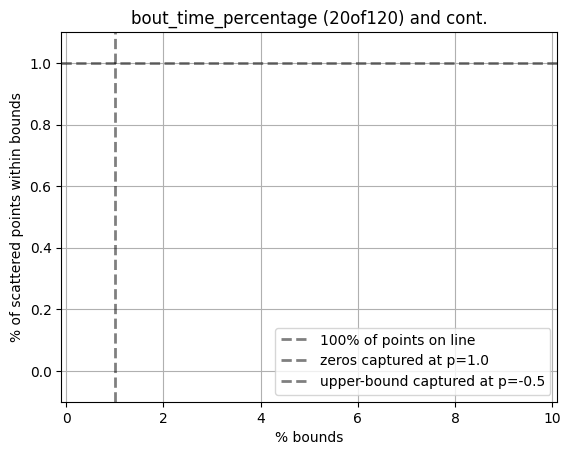

In [30]:
test_dc = points_dc[points_dc!=0].dropna()
test_c = points_c.loc[test_dc.index]
filt_dc = (test_dc.values>test_c.values*(1+p))|(test_dc.values<test_c.values*(1-p))
points_on_line = percent_points_in_bounds[0]
upper_bound_points = (1/2)-1
zero_bound_points = 1.0

plt.title(f'{data_params["metric_tag"]} ({dc_col}) and cont.')
plt.plot(p, percent_points_in_bounds)
plt.axhline(y=points_on_line, label=f'{round(100*points_on_line)}% of points on line',
            linestyle='dashed', color='k', linewidth=2, alpha=0.5)
plt.axvline(x=zero_bound_points, label=f'zeros captured at p={zero_bound_points}',
            linestyle='dashed', color='k', linewidth=2, alpha=0.5)
plt.axvline(x=upper_bound_points, label=f'upper-bound captured at p={upper_bound_points}',
            linestyle='dashed', color='k', linewidth=2, alpha=0.5)
plt.grid(which='both')
plt.xlabel('% bounds')
plt.xlim(-0.1, 10.1)
plt.ylim(-0.1, 1.1)
plt.ylabel('% of scattered points within bounds')
plt.legend(loc=4)

plt.show()

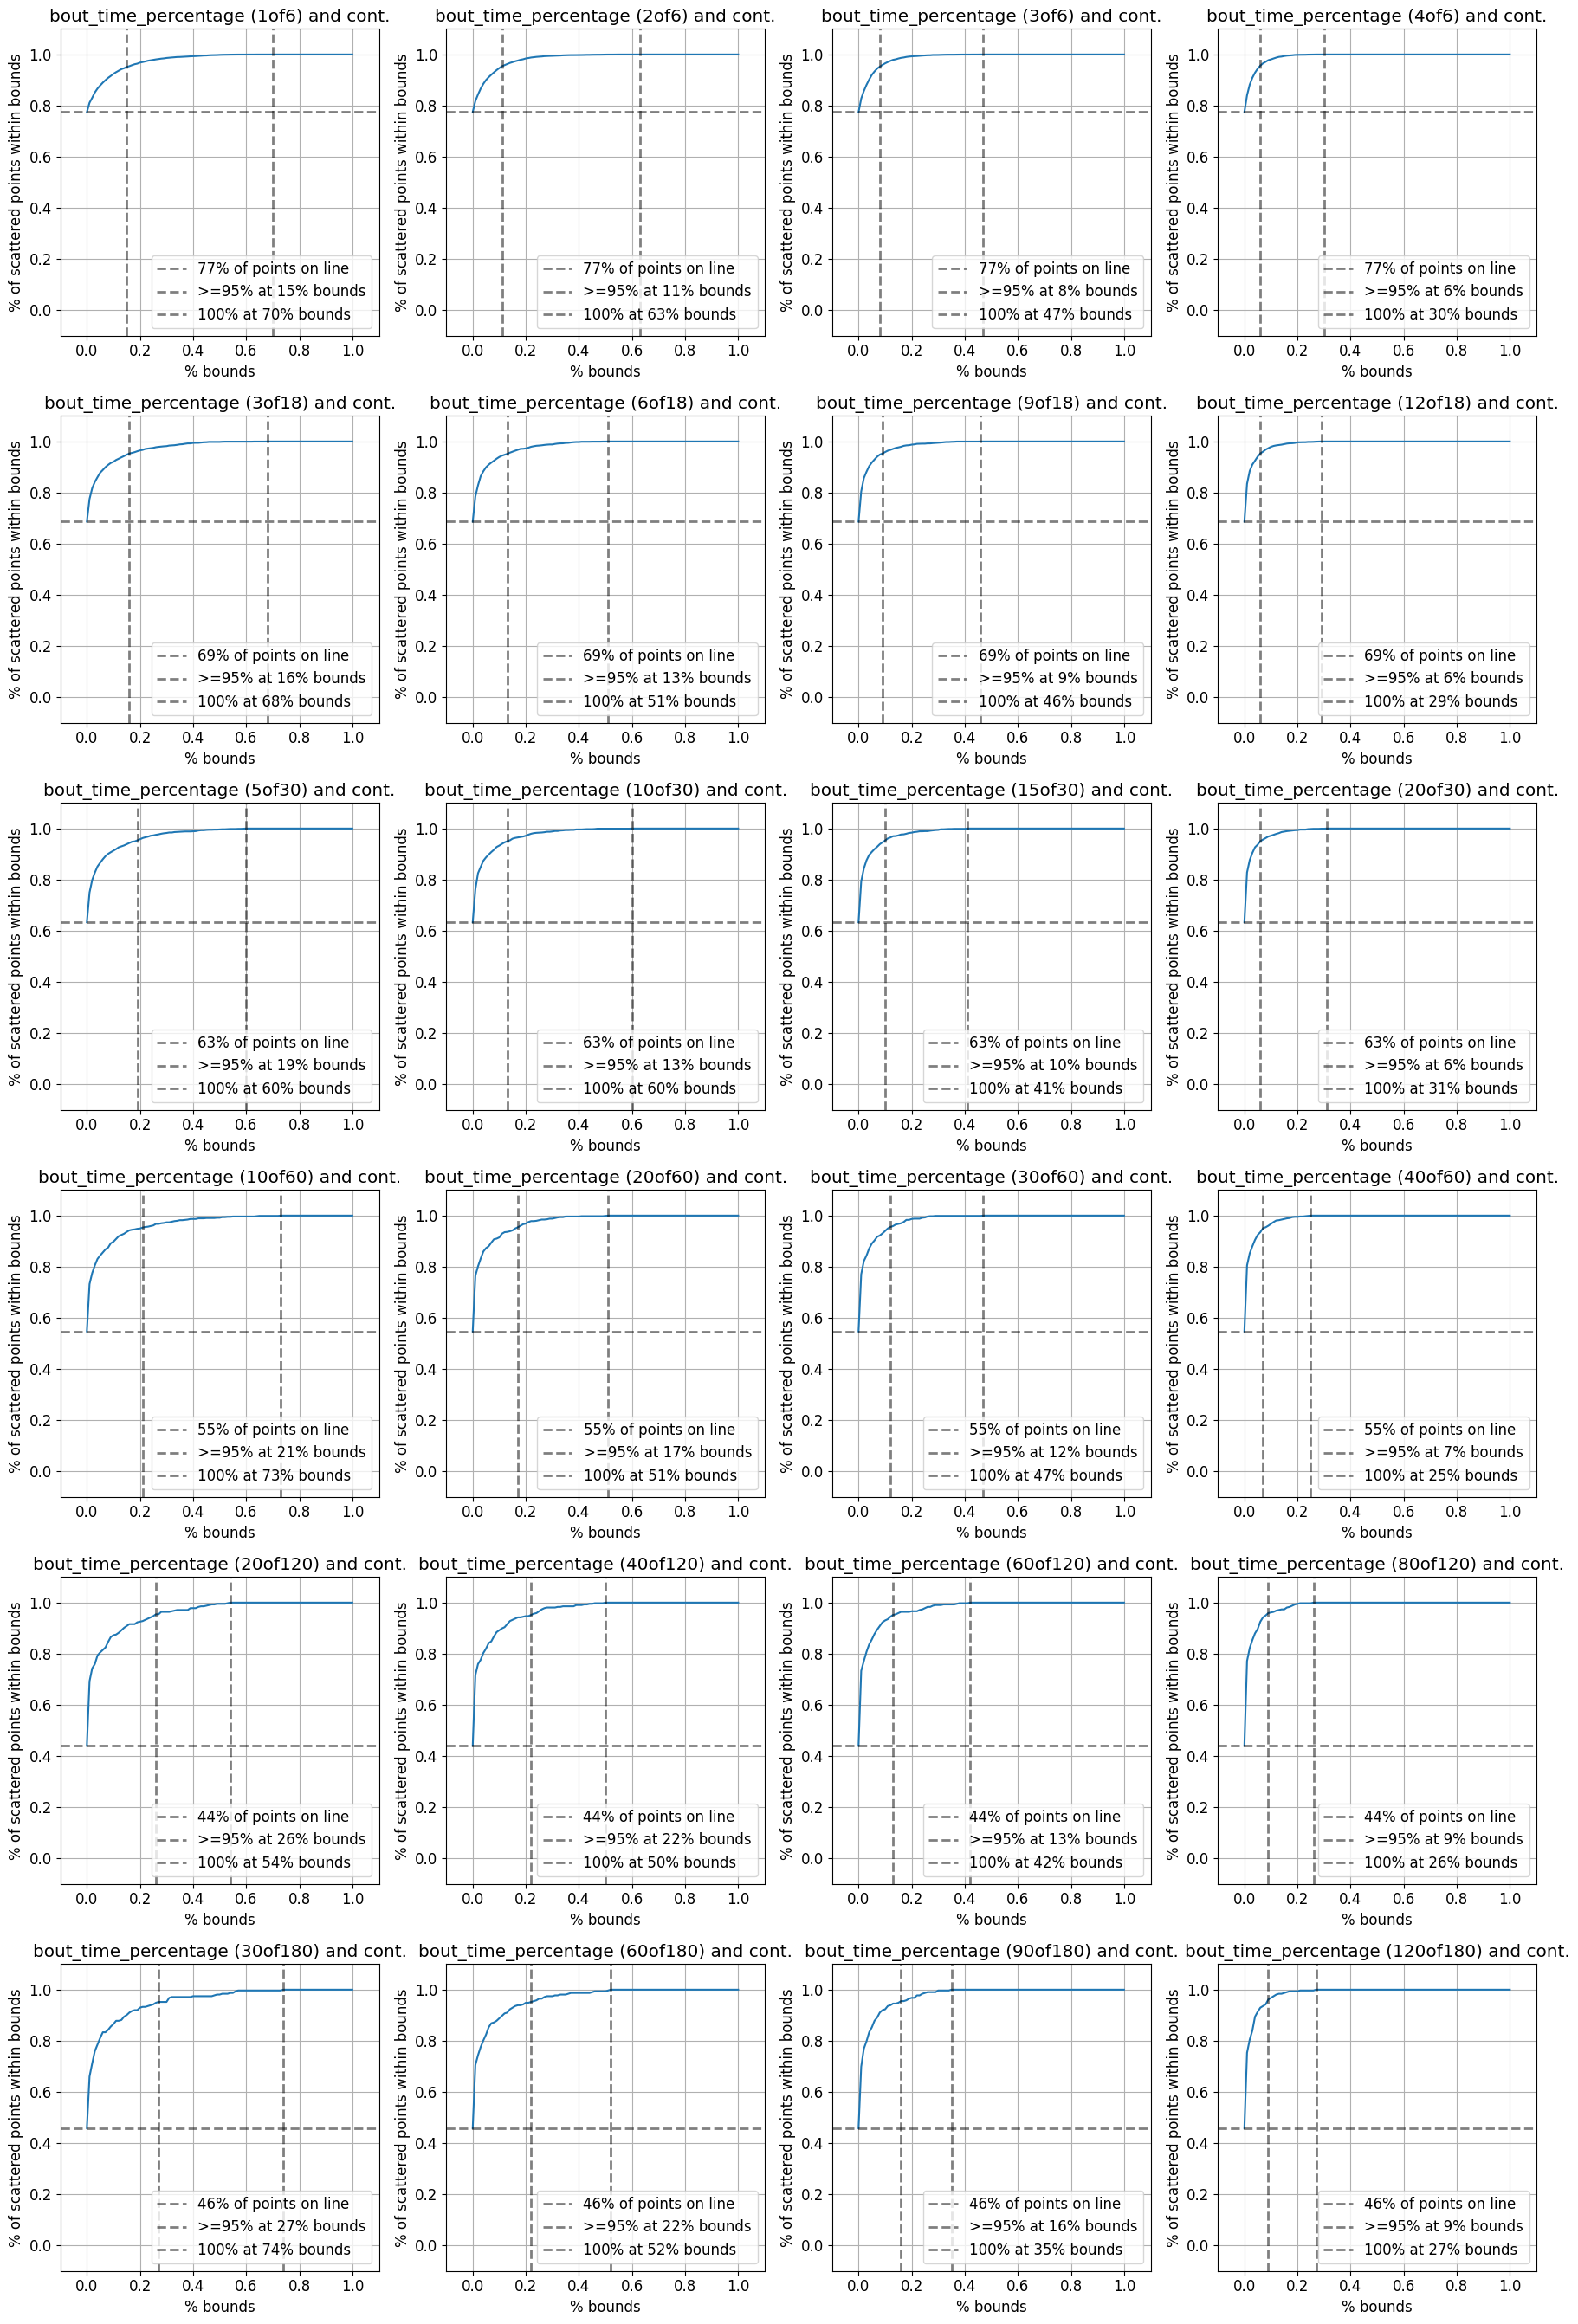

In [22]:
plot_all_dc_scheme_variance_of_points_linear(activity_arr, btp_arr, data_params)

IndexError: index 0 is out of bounds for axis 0 with size 0

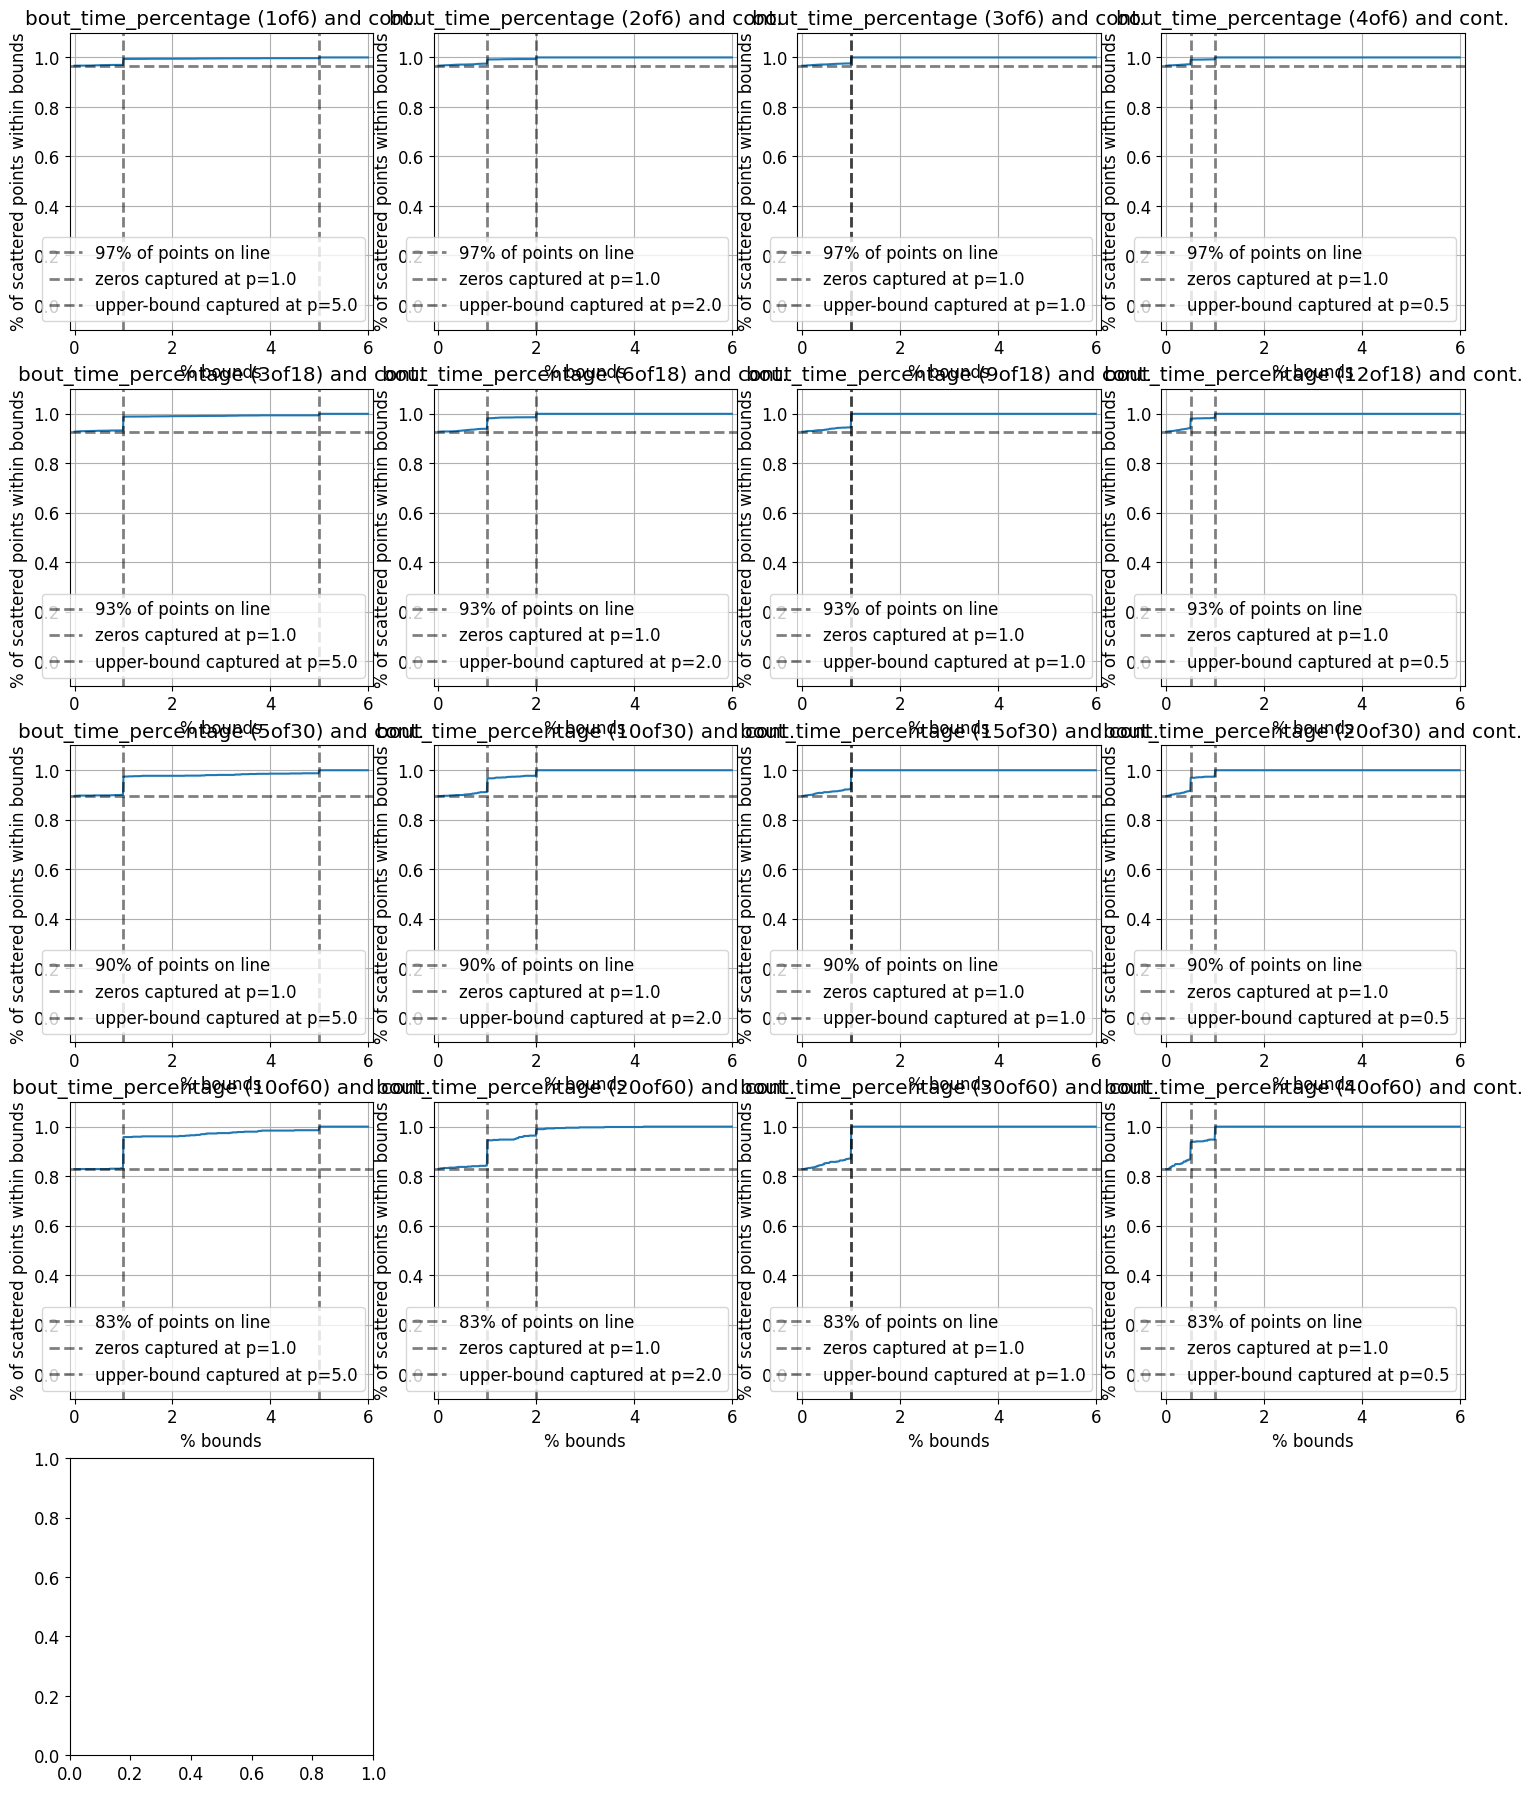

In [37]:
plot_all_dc_scheme_variance_of_points_log(activity_arr, btp_arr, data_params)

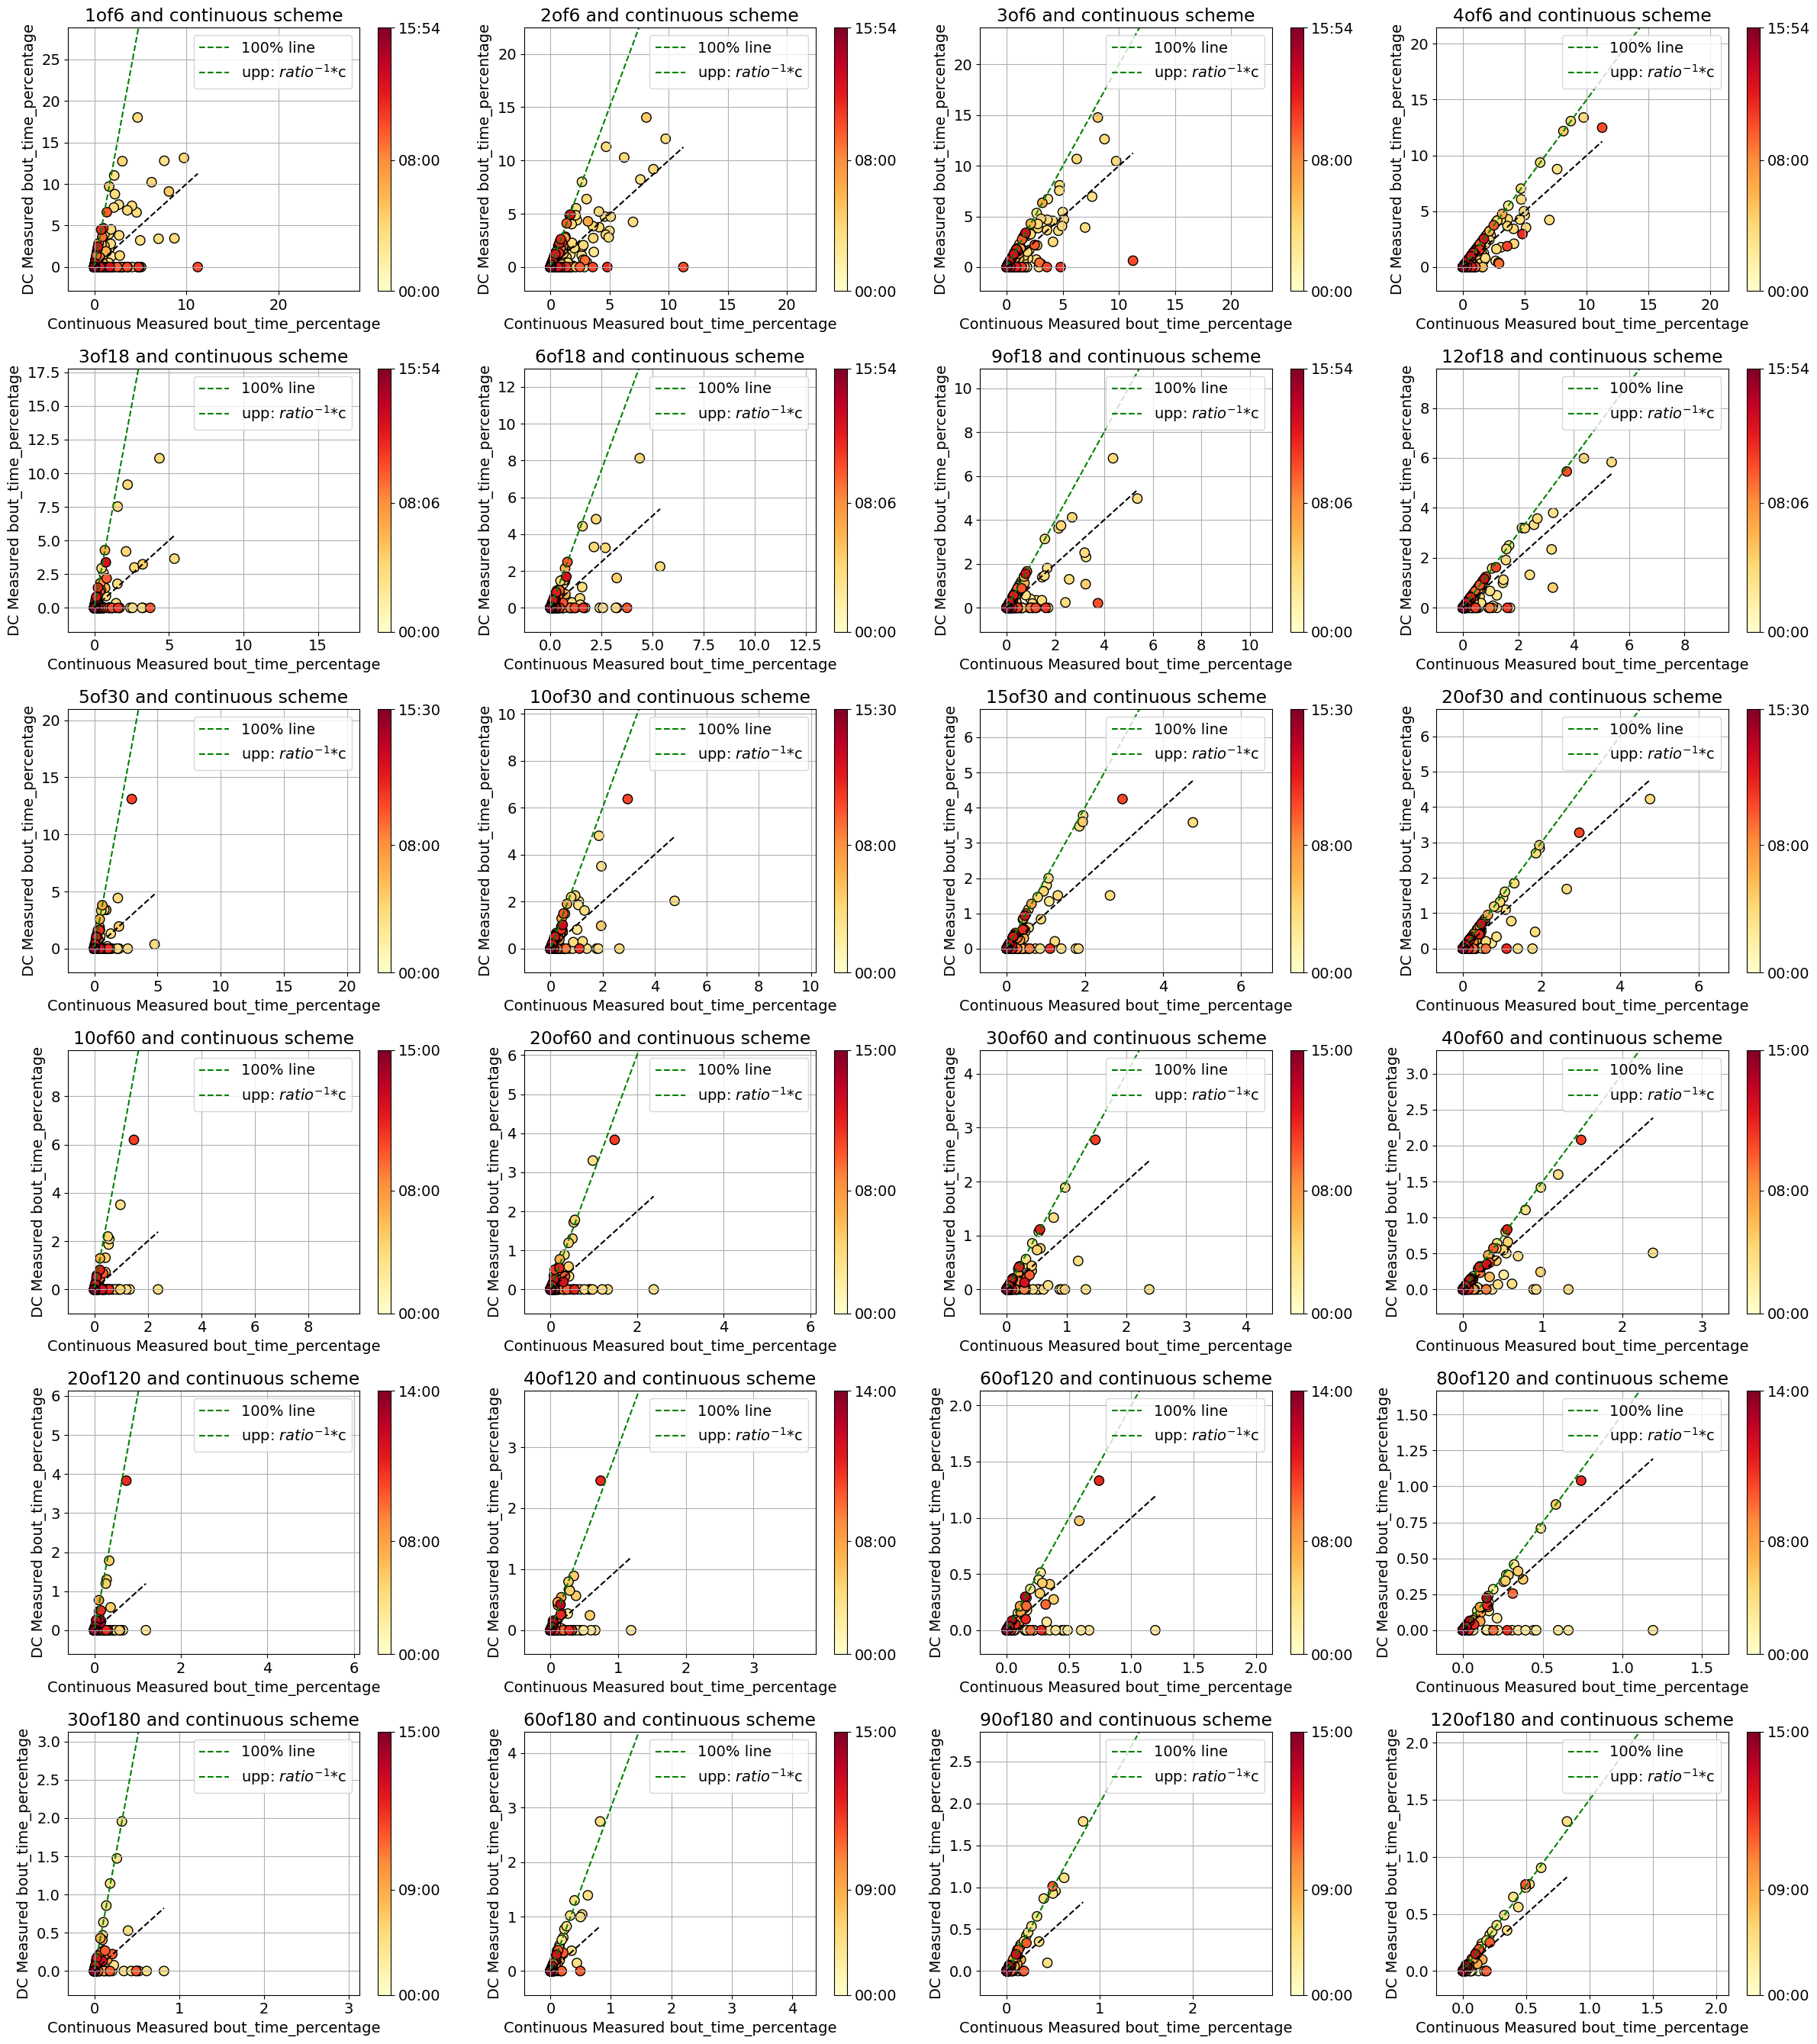

In [36]:
complot.plot_all_dc_scheme_comps_linear_scale(activity_arr, btp_arr, data_params)